# Semi-Global Matching with Numpy

This notebook demonstates how to use Heiko Hirschmuller's [semi-global matching](https://core.ac.uk/download/pdf/11134866.pdf) techinque to estimate depth using rectified stereo images. This python implementation originated from David-Alexandre Beaupre's [implementation in python](https://github.com/beaupreda/semi-global-matching). SGM is a popular classic depth estimation algorithm, known for having good accuracy for its speed. Its widely used in resource constrained  situations. 

All the operations required to perform sgm are created from scratch in numpy. This provides fine grained control over the algorithm. Disparities for both the left and right images will be calculated and compared against the ground truth disparity to measure the algorithms accuracy. Note that in a high peformance production environment, usually disparity for only one image is created. Brief explanations will be provided for each step in the process.

In [4]:
import argparse
import sys
import time as t

import cv2
import numpy as np
from matplotlib import cm
from PIL import Image
from IPython.display import display

In [2]:
left_name = 'cones/im2.png' # name (path) to the left image
right_name = 'cones/im6.png' # name (path) to the right image
left_gt_name = 'cones/disp2.png' # name (path) to the left ground-truth image
right_gt_name = 'cones/disp6.png' # name (path) to the right ground-truth image
max_disparity = 64 # maximum disparity for the stereo pair
P1 = 10 # penalty for disparity difference = 1
P2 = 120 # penalty for disparity difference > 1
csize = (5, 5) # size of the kernel for the census transform.
bsize = (3, 3) # size of the kernel for blurring the images and median filtering.

### Load The Images

The images are loaded into grayscale format. We will only be using the intensities of the pixels, so the RGB information is not needed.

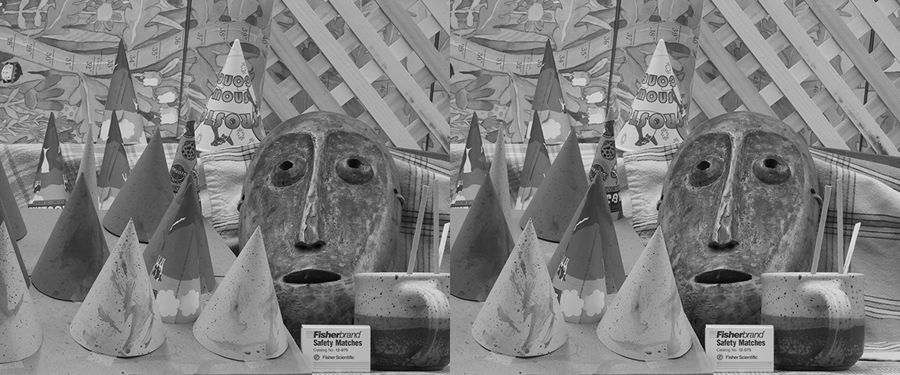

In [7]:
left = cv2.imread(left_name, cv2.IMREAD_GRAYSCALE)
right = cv2.imread(right_name, cv2.IMREAD_GRAYSCALE)

height = left.shape[0]
width = left.shape[1]
assert left.shape[0] == right.shape[0] and left.shape[1] == right.shape[1], 'left & right must have the same shape.'
assert max_disparity > 0, 'maximum disparity must be greater than 0.'

joined_gray = np.concatenate([left, right], axis=1)
display(Image.fromarray(joined_gray))

### Smooth The Images

A Gaussian blur filter is applied to the images, which smooths the images.

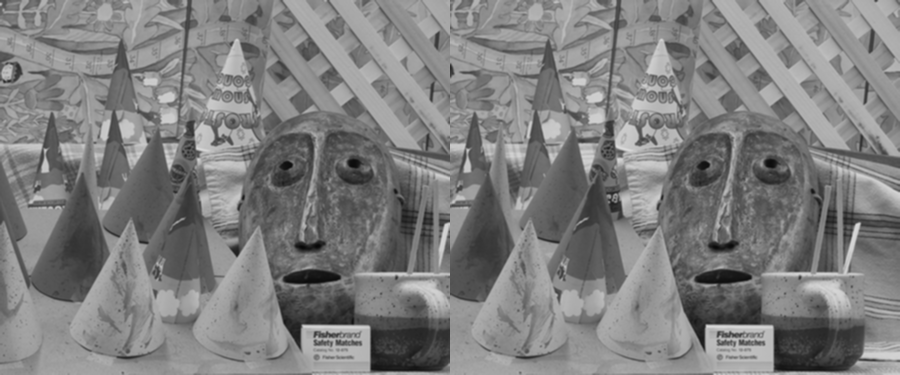

In [6]:
left = cv2.GaussianBlur(left, bsize, 0, 0)
right = cv2.GaussianBlur(right, bsize, 0, 0)

joined_smoothed = np.concatenate([left, right], axis=1)
display(Image.fromarray(joined_smoothed))

### Census Transform

Disparity estimation is a correspondance problem. We are essentially trying to find how far a point in the left image has moved in the right image, which will give us the disparity of that pixel in the left image. This operation is then applied to all the pixels to get the disparity map. 

To find the pixel in the other image we need to use unique information about the point to ensure we match the correct point. We could try use the pixels intensity (RGB or grayscale) to find the point. However, this information is not unique enough and will result in many false matches. Another method is to use the mean or variance intensities of a block of pixels around the target pixel. These are called parametric measures. Parametric measures suffer from a problem called factionalism, which can result in a situation where a minority of neighbourhood pixels have an outsized impact on the value. This results in poor correspondance near objects boundaries.

We will be using a non-parametric method called the census transform. The census transform relies on the ordering of the neighborhood pixel intensities and not the values themselves. The census transform creates a bit string from the relative intensities of the neighbouring pixels. If the neighbouring pixels intensity is less then the target pixels intensity then 1 is added to the bit string, otherwise 0 is added. This operation is repeated for all the target pixels neighbours to create a bit string. The ordering of the bits in the bit string will contain enough information to perform an accurate and fast correspondance operation. Take for example a center pixel (intensity 130) with a 3 x 3 block of neighbours with the following values:
$$\begin{bmatrix} 200 & 180 & 10 \\ 40 & 130 & 80 \\ 174 & 178 & 190 \end{bmatrix}$$
The census transformation will be:  
$$\begin{bmatrix} 0 & 0 & 1 \\ 1 &  & 1 \\ 0 & 0 & 0 \end{bmatrix}$$
Then flattened into a bit string it takes the form: $00111000$.

See R Zabih and J Woodfill's CENSUS paper for more details: [Nonparametric Local Transforms for Computing Visual Correspondence](http://www.cs.cornell.edu/~rdz/Papers/ZW-ECCV94.pdf)

### Compute The Census Values

The function "compute_census" computes the census values for each pixel in the left and right images using the methods described above. The census bit strings are stored in the form of a numpy integer. "csize" determines the size of the block of neighbours around the center pixel. More neighbours means more information stored per pixel but also more computation time. Larger kernel sizes need larger integers, for example a (7, 7) kernel will need $7 * 7 - 1= 48$ bits of memory, so an int64 will be needed so store all the census data. (5, 5) kernel will need int32 and (3, 3) can use int8. 

In [8]:
def compute_census(left, right, csize, height, width):
    """
    Calculate census bit strings for each pixel in the left and right images.
    Arguments:
        - left: left grayscale image.
        - right: right grayscale image.
        - csize: kernel size for the census transform.
        - height: number of rows of the image.
        - width: number of columns of the image.

    Return: Left and right images with pixel intensities replaced with census bit strings.
    """
    cheight = csize[0]
    cwidth = csize[1]
    y_offset = int(cheight / 2)
    x_offset = int(cwidth / 2)

    left_census_values = np.zeros(shape=(height, width), dtype=np.uint64)
    right_census_values = np.zeros(shape=(height, width), dtype=np.uint64)

    print('\tComputing left and right census...', end='')
    sys.stdout.flush()
    dawn = t.time()
    # offset is used since pixels on the border will have no census values
    for y in range(y_offset, height - y_offset):
        for x in range(x_offset, width - x_offset):
            # left
            center_pixel = left[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int32)
            image = left[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            # If value is less than center value assign 1 otherwise assign 0 
            left_census_pixel_array = np.where(comparison < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            left_census_pixel = np.int32(left_census_pixel_array.dot(1 << np.arange(cheight * cwidth)[::-1])) 
            left_census_values[y, x] = left_census_pixel

            # right
            center_pixel = right[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int32)
            image = right[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            # If value is less than center value assign 1 otherwise assign 0 
            right_census_pixel_array = np.where(comparison < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            right_census_pixel = np.int32(right_census_pixel_array.dot(1 << np.arange(cheight * cwidth)[::-1])) 
            right_census_values[y, x] = right_census_pixel

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_census_values, right_census_values

In [9]:
left_census, right_census = compute_census(left, right, csize, height, width)

	Computing left and right census...	(done in 3.52s)


Now that the census bit strings are in integer format, they can be converted to uint8 for visualization. The census images capture the information of the edges very well. 

This is a condensed form of the census information. The first neighbours will have an exponentially higher weighting on the pixel intensity than the last neighbours. This essentially means that the last neighbours in the census have no impact on the images displayed below. But its still nice to see the information visualized.

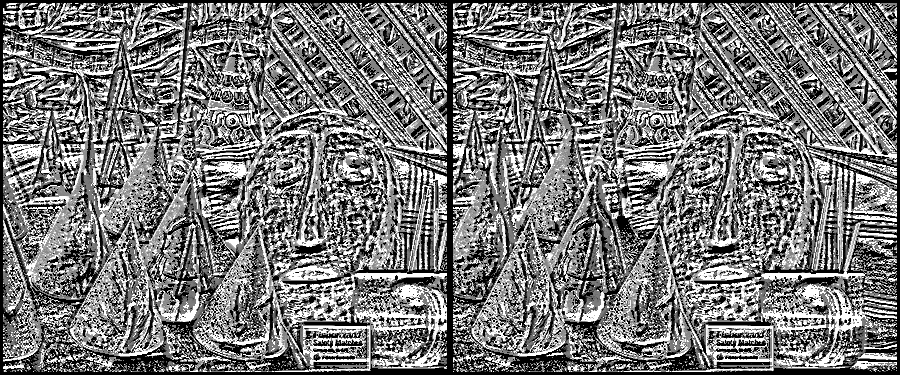

In [10]:
joined_census = np.concatenate([np.uint8(left_census), np.uint8(right_census)], axis=1)
display(Image.fromarray(joined_census))

### Hamming Distance

Now we need a way to measure the similarity of the pixels (a similarity measure). For this job we will use the hamming distance. The hamming distance sums up the number of different bits in both pixels bit strings. Lower hamming distance means higher similarity. Take for example two pixels, $p1$ and $p2$ with bit strings: $$p1 = 0101$$ and $$p2 = 0111$$.Their hamming distance is 1, since they differ at only one position (the second position from the right).

### Compute Costs

We now have a unique identifier for each pixel (the census bit string). We need to use the census values together with the hamming distance to find the most likely match in the corresponding image. We do this by measuring the matching costs of the pixel with the corresponding pixel in the other image for each disparity integer up until the "max_disparity" number. The matching costs are calculated using the Hamming distance defined above. This operation is performed in a vectorized way. The costs for one disparity level are calculated for all pixels in the image in one pass. 

All the costs for all pixels at all diparity levels are stored in an array with dimension (height x width x max_disparity). This array is called the cost volume. The disparity map can be determined directly from the cost volume by finding the disparity with minimum cost for each pixel. This method works, but produces a very noisy disparity map (as you will see below). SGM will use a post filtering step before extracting the disparity map, called cost aggregation.

In [11]:
def compute_costs(left_census_values, right_census_values, max_disparity, csize, height, width):
    """
    Create cost volume for all potential disparities. 
    Cost volumes for both left and right images are calculated.
    Hamming distance is used to calculate the matching cost between 
    two pixels census values.
    Arguments:
        - left_census_values: left image containing census bit strings for each pixel (in integer form).
        - right_census_values: right image containing census bit strings for each pixel (in integer form).
        - max_disparity: maximum disparity to measure.
        - csize: kernel size for the census transform.
        - height: number of rows of the image.
        - width: number of columns of the image.

    Return: Left and right cost volumes with dimensions H x W x D.
    """
    cwidth = csize[1]
    x_offset = int(cwidth / 2)

    print('\tComputing cost volumes...', end='')
    sys.stdout.flush()
    dawn = t.time()
    left_cost_volume = np.zeros(shape=(height, width, max_disparity), dtype=np.uint32)
    right_cost_volume = np.zeros(shape=(height, width, max_disparity), dtype=np.uint32)
    lcensus = np.zeros(shape=(height, width), dtype=np.int32)
    rcensus = np.zeros(shape=(height, width), dtype=np.int32)

    for d in range(0, max_disparity):
        # The right image is shifted d pixels accross
        rcensus[:, (x_offset + d):(width - x_offset)] = right_census_values[:, x_offset:(width - d - x_offset)]
        # 1 is assigned when the bits differ and 0 when they are the same
        left_xor = np.int32(np.bitwise_xor(np.int32(left_census_values), rcensus))
        # All the 1's are summed up to give us the number of different pixels (the cost)
        left_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(left_xor == 0):
            tmp = left_xor - 1
            mask = left_xor != 0
            left_xor[mask] = np.bitwise_and(left_xor[mask], tmp[mask])
            left_distance[mask] = left_distance[mask] + 1
        # All the costs for that disparity are added to the cost volume
        left_cost_volume[:, :, d] = left_distance

        # The left image is shifted d pixels accross
        lcensus[:, x_offset:(width - d - x_offset)] = left_census_values[:, (x_offset + d):(width - x_offset)]
        # 1 is assigned when the bits differ and 0 when they are the same
        right_xor = np.int32(np.bitwise_xor(np.int32(right_census_values), lcensus))
        # All the 1's are summed up to give us the number of different pixels (the cost)
        right_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(right_xor == 0):
            tmp = right_xor - 1
            mask = right_xor != 0
            right_xor[mask] = np.bitwise_and(right_xor[mask], tmp[mask])
            right_distance[mask] = right_distance[mask] + 1
        # All the costs for that disparity are added to the cost volume
        right_cost_volume[:, :, d] = right_distance

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_cost_volume, right_cost_volume

In [12]:
left_cost_volume, right_cost_volume = compute_costs(left_census, right_census, max_disparity, csize, height, width)

	Computing cost volumes...	(done in 8.52s)


In [13]:
def normalize(disp, max_disparity):
    """
    Normalizes the disparity map, then
    quantizes it so that it can be displayed. 
    Arguments:
        - disp: disparity map with dimensions H x W.
        - max_disparity: maximum disparity of the array.
    
    Return: normalized then quantized array, ready for visualization.
    """
    return 255.0 * disp / max_disparity

The disparity maps are extracted from the left and right cost volumes by using the disparity with the lowest matching cost for each pixel. As you can see below the disparity maps are good but very noisy. This issue will be fixed in the next step, cost aggregation. 

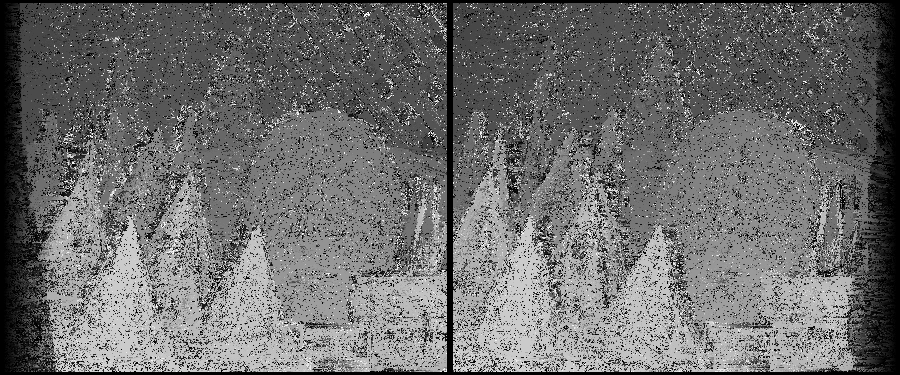

In [14]:
left_costs = np.uint8(normalize(np.argmin(left_cost_volume, axis=2), max_disparity))
right_costs = np.uint8(normalize(np.argmin(right_cost_volume, axis=2), max_disparity))

joined_costs = np.concatenate([left_costs, right_costs], axis=1)
display(Image.fromarray(joined_costs))

In [15]:
def get_penalties(max_disparity, P2, P1):
    """
    Creates a matrix of all the potential penalties for matching
    a current disparity (represented by the column index), with 
    a previous disparity (represented by the row index).
    Arguments:
        - max_disparity: Maximum disparity of the array.
        - P2: Penalty for disparity difference > 1
        - P1: Penalty for disparity difference = 1
    
    Return: Matrix containing all the penalties when disparity d1 from a column
            is matched with a previous disparity d2 from the row.
    """
    p2 = np.full(shape=(max_disparity, max_disparity), fill_value=P2, dtype=np.uint32)
    p1 = np.full(shape=(max_disparity, max_disparity), fill_value=P1 - P2, dtype=np.uint32)
    p1 = np.tril(p1, k=1) # keep values lower than k'th diagonal
    p1 = np.triu(p1, k=-1) # keep values higher than k'th diagonal
    no_penalty = np.identity(max_disparity, dtype=np.uint32) * -P1 # create diagonal matrix with values -p1
    penalties = p1 + p2 + no_penalty
    return penalties


def get_path_cost(slice, offset, penalties, other_dim, disparity_dim):
    """
    Calculates the minimum costs for all potential disparities of 
    the pixels along a single path direction.
    Arguments:
        - slice: Array containing costs for all disparities, D, 
            along a direction, M, with dimension M x D
        - offset: Number of pixels on the border to ignore.
        - penalties: Matrix containing the penalties to assign to the 
            previous disparities costs. For previous disparities that differ 
            from current disparities. 
        - other_dim: Number of pixels in the current paths direction.
        - disparity_dim: Number of disparities to calculate minimum costs.

    Returns: The pixels minimum costs for all disparities, D, 
        along path direction, M, with shape M x D.
    """
    minimum_cost_path = np.zeros(shape=(other_dim, disparity_dim), dtype=np.uint32)
    minimum_cost_path[offset - 1, :] = slice[offset - 1, :]

    for pixel_index in range(offset, other_dim):
        # Get all the minimum disparities costs from the previous pixel in the path
        previous_cost = minimum_cost_path[pixel_index - 1, :]
        # Get all the disparities costs (from the cost volume) for the current pixel
        current_cost = slice[pixel_index, :]
        costs = np.repeat(previous_cost, repeats=disparity_dim, axis=0).reshape(disparity_dim, disparity_dim)
        # Add penalties to the previous pixels disparities that differ from current pixels disparities
        costs = costs + penalties
        # Find minimum costs for the current pixels disparities using the previous disparities costs + penalties 
        costs = np.amin(costs, axis=0)  
        # Current pixels disparities costs + minimum previous pixel disparities costs (with penalty) - 
        # (constant term) minimum previous cost from all disparities 
        pixel_direction_costs = current_cost + costs - np.amin(previous_cost)
        minimum_cost_path[pixel_index, :] = pixel_direction_costs

    return minimum_cost_path    


def aggregate_costs(cost_volume, P2, P1, height, width, disparities):
    """
    Calculates the pixels costs for all disparities along all paths (4 in this case).

    Arguments: 
        - cost_volume: Array containing the matching cost for each pixel at each disparity.
        - P2: Penalty for disparity difference > 1
        - P1: Penalty for disparity difference = 1
        - height: Number of rows of the image.
        - width: Number of columns of the image.
        - disparities: Number of disparities to calculate minimum matching costs.

    Returns: Array containing the pixels matching costs for all disparities along 
        all directions, with dimension H x W x D X 4.
    """
    penalties = get_penalties(disparities, P2, P1)

    print("Processing North and South aggregation")
    south_aggregation = np.zeros(shape=(height, width, disparities), dtype=np.uint32)
    north_aggregation = np.copy(south_aggregation)

    for x in range(0, width):
        # Takes all the rows and disparities for a single column
        south = cost_volume[:, x, :]
        # Invert the rows to get the opposite direction
        north = np.flip(south, axis=0)
        south_aggregation[:, x, :] = get_path_cost(south, 1, penalties, height, disparities)
        north_aggregation[:, x, :] = np.flip(get_path_cost(north, 1, penalties, height, disparities), axis=0)


    print("Processing East and West aggregation.")
    east_aggregation = np.copy(south_aggregation)
    west_aggregation = np.copy(south_aggregation)
    for y in range(0, height):
        # Takes all the column and disparities for a single row
        east = cost_volume[y, :, :]
        # Invert the columns to get the opposite direction
        west = np.flip(east, axis=0)
        east_aggregation[y, :, :] = get_path_cost(east, 1, penalties, width, disparities)
        west_aggregation[y, :, :] = np.flip(get_path_cost(west, 1, penalties, width, disparities), axis=0)

    # Combine the costs from all paths into a single aggregation volume
    aggregation_volume = np.concatenate((south_aggregation[..., None], north_aggregation[..., None], east_aggregation[..., None], west_aggregation[..., None]), axis=3)
    
    return aggregation_volume

In [16]:
get_penalties(max_disparity, P2, P1)

array([[  0,  10, 120, ..., 120, 120, 120],
       [ 10,   0,  10, ..., 120, 120, 120],
       [120,  10,   0, ..., 120, 120, 120],
       ...,
       [120, 120, 120, ...,   0,  10, 120],
       [120, 120, 120, ...,  10,   0,  10],
       [120, 120, 120, ..., 120,  10,   0]])

In [17]:
print('\nStarting left aggregation computation...')
left_aggregation_volume = aggregate_costs(left_cost_volume, P2, P1, height, width, max_disparity)


Starting left aggregation computation...
Processing North and South aggregation
Processing East and West aggregation.


In [18]:
print('\nStarting right aggregation computation...')
right_aggregation_volume = aggregate_costs(right_cost_volume, P2, P1, height, width, max_disparity)


Starting right aggregation computation...
Processing North and South aggregation
Processing East and West aggregation.


In [19]:
def select_disparity(aggregation_volume):
    """
    last step of the sgm algorithm, corresponding to equation 14 followed by winner-takes-all approach.
    :param aggregation_volume: H x W x D x N array of matching cost for all defined directions.
    :return: H x W disparity image.
    """
    volume = np.sum(aggregation_volume, axis=3) # sum up costs for all directions
    disparity_map = np.argmin(volume, axis=2) # returns the disparity index with the minimum cost associated with each h x w pixel
    return disparity_map

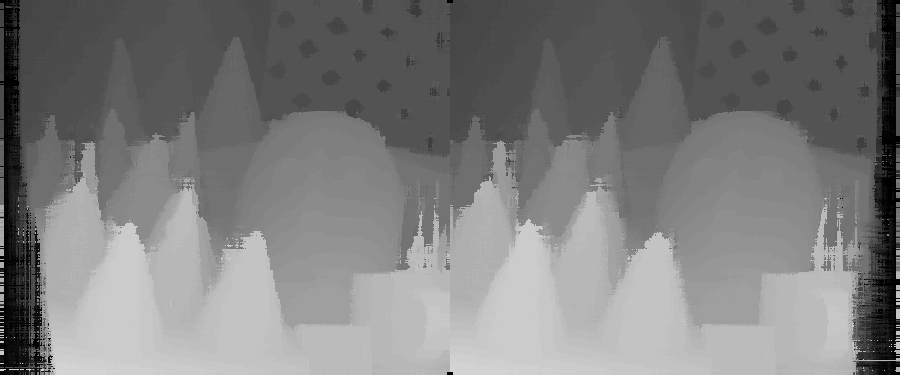

In [31]:
left_disparity_map = np.uint8(normalize(select_disparity(left_aggregation_volume), max_disparity))
right_disparity_map = np.uint8(normalize(select_disparity(right_aggregation_volume), max_disparity))

joined_disparity_map = np.concatenate([left_disparity_map, right_disparity_map], axis=1)
display(Image.fromarray(joined_disparity_map))

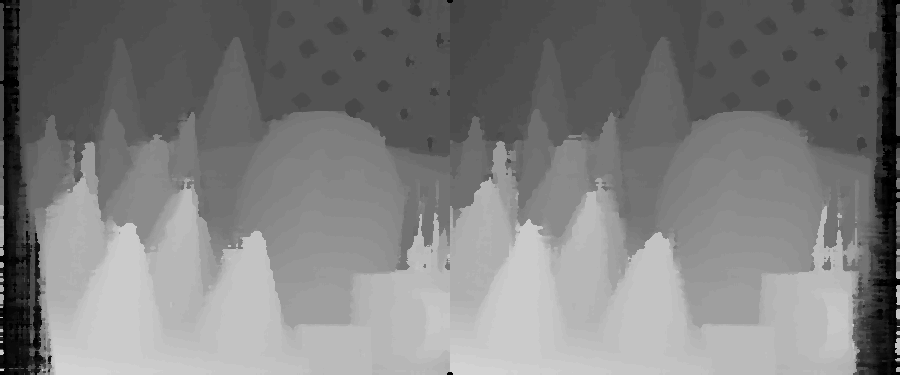

In [30]:
left_disparity_map_smoothed = cv2.medianBlur(left_disparity_map, bsize[0])
right_disparity_map_smoothed = cv2.medianBlur(right_disparity_map, bsize[0])

joined_disparity_map_smoothed = np.concatenate([left_disparity_map_smoothed, right_disparity_map_smoothed], axis=1)
display(Image.fromarray(joined_disparity_map_smoothed))

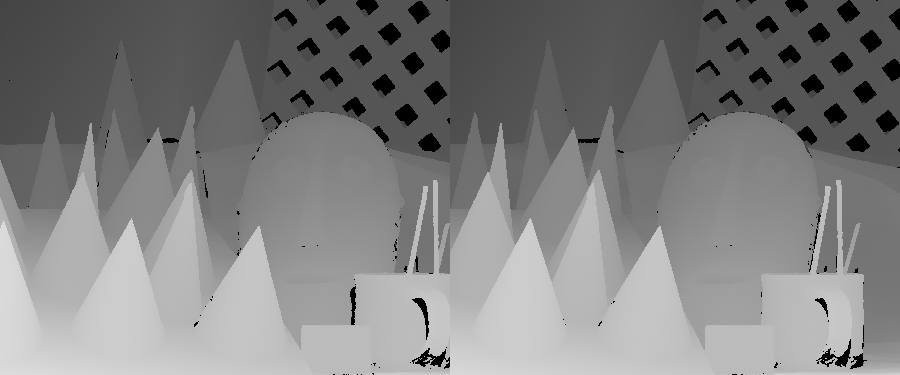

In [29]:
left_gt = cv2.imread(left_gt_name, cv2.IMREAD_GRAYSCALE)
right_gt = cv2.imread(right_gt_name, cv2.IMREAD_GRAYSCALE)

joined_gt = np.concatenate([left_gt, right_gt], axis=1)
display(Image.fromarray(joined_gt))

In [24]:
def get_recall(disparity, gt, max_disparity):
    """
    computes the recall of the disparity map.
    :param disparity: disparity image.
    :param gt: ground-truth image.
    :param max_disparity: maximum disparity for the stereo pair.
    :return: rate of correct predictions.
    """
    gt = np.float32(gt)
    gt = np.int16(gt / 255.0 * float(max_disparity))
    disparity = np.int16(np.float32(disparity) / 255.0 * float(max_disparity))
    correct = np.count_nonzero(np.abs(disparity - gt) <= 3)
    return float(correct) / gt.size

In [25]:
print('\nEvaluating left disparity map...')
recall = get_recall(left_disparity_map, left_gt, max_disparity)
print('\tRecall = {:.2f}%'.format(recall * 100.0))
print('\nEvaluating right disparity map...')
recall = get_recall(right_disparity_map, right_gt, max_disparity)
print('\tRecall = {:.2f}%'.format(recall * 100.0))


Evaluating left disparity map...
	Recall = 85.72%

Evaluating right disparity map...
	Recall = 85.87%


In [27]:
def create_depth_map(disp, cmap='jet'):
    """
    Converts single channel disparity map
    to an RGB depth map.
    Arguments:
      - disp: Quantized (uint8) disparity map with dimensions H x W 
      - cmap: a valid cmap named for use with matplotlib's 'get_cmap'
    
    Returns an RGB depth map with dimension H x W x 3.
    """
    color_map = cm.get_cmap(cmap)
    colors = color_map(np.arange(256))[:, :3].astype(np.float32)
    depth_map = np.take(colors, disp, axis=0)
    depth_map = np.uint8(depth_map * 255)
    return depth_map

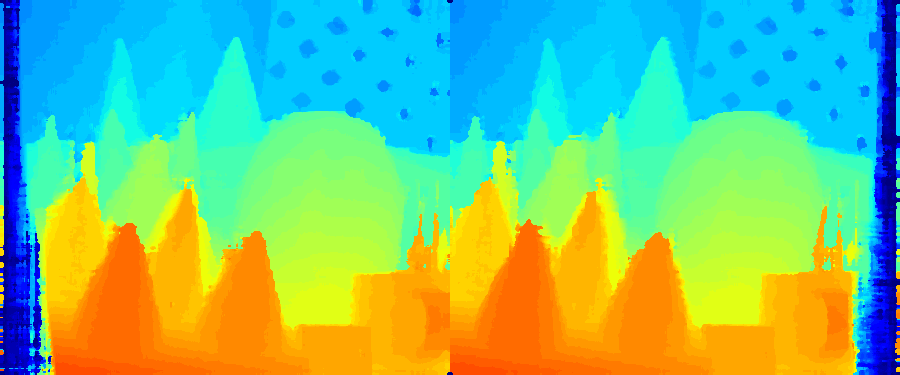

In [33]:
left_depth_map = create_depth_map(left_disparity_map_smoothed)
right_depth_map = create_depth_map(right_disparity_map_smoothed)

joined_depth_map = np.concatenate([left_depth_map, right_depth_map], axis=1)
display(Image.fromarray(joined_depth_map))

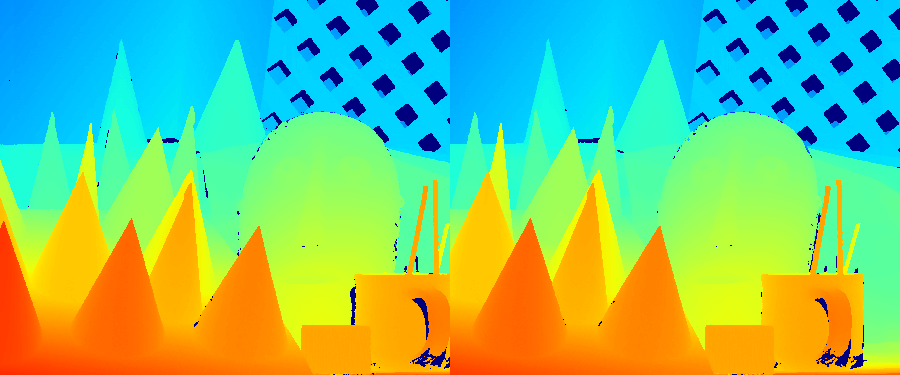

In [34]:
left_depth_map_gt = create_depth_map(left_gt)
right_depth_map_gt = create_depth_map(right_gt)

joined_depth_map_gt = np.concatenate([left_depth_map_gt, right_depth_map_gt], axis=1)
display(Image.fromarray(joined_depth_map_gt))